**Classifying users by personality type using their biographies**

**Loading the dataset**

In [81]:
!nvidia-smi

Thu Oct  7 19:50:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.13       Driver Version: 462.13       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 307... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8    10W /  N/A |   4653MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [82]:
import ast 
import sklearn
import pandas as pd
import transformers
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from ast import literal_eval
import seaborn as sns
import time
import datetime

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification

from tqdm import tqdm, trange
import pandas as pd
import io
import pickle
import os

In [126]:
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

folder_path = 'C:/Users/parth/PycharmProjects/Language Models/Data/master_v2.3.csv'

origin_df = pd.read_pickle(folder_path)

origin_df.columns

Index(['extravert', 'follow_back_pic_urls', 'follow_bios',
       'follow_follows_counts', 'follow_profile_pic_urls',
       'follow_stats_counts', 'intuitive', 'judging', 'lang', 'liked_media',
       'liked_tweets', 'own_media', 'statuses', 'thinking', 'type', 'user_id',
       'screen_name', 'name', 'bio', 'favorites_count:', 'statuses_count',
       'follows_count', 'profile_back_url', 'profile_pic_url', 'queried_at',
       'profile_embedding_resnet50', 'image_array'],
      dtype='object')

In [84]:
df = origin_df[['extravert', 'thinking', 'intuitive', 'judging', 'bio', 'liked_tweets', 'statuses']].sample(frac = 1).reset_index(drop = True)

In [112]:
def sanitize(x):
  x = x.replace("INTP", "")
  x = x.replace("INTJ", "")
  x = x.replace("INFP", "")
  x = x.replace("INFJ", "")
  x = x.replace("ISTP", "")
  x = x.replace("ISTJ", "")
  x = x.replace("ISFP", "")
  x = x.replace("ISFJ", "")
  x = x.replace("ENTP", "")
  x = x.replace("ENTJ", "")
  x = x.replace("ENFP", "")
  x = x.replace("ENFJ", "")
  x = x.replace("ESTP", "")
  x = x.replace("ESTJ", "")
  x = x.replace("ESFP", "")
  x = x.replace("ESFJ", "")
  x = x.replace("intp", "")
  x = x.replace("intj", "")
  x = x.replace("infp", "")
  x = x.replace("infj", "")
  x = x.replace("istp", "")
  x = x.replace("istj", "")
  x = x.replace("isfp", "")
  x = x.replace("isfj", "")
  x = x.replace("entp", "")
  x = x.replace("entj", "")
  x = x.replace("enfp", "")
  x = x.replace("enfj", "")
  x = x.replace("estp", "")
  x = x.replace("estj", "")
  x = x.replace("esfp", "")
  x = x.replace("esfj", "")

  return x

def remove_urls(x):
  r = ''
  s = x.split()
  for word in s:
    if word.startswith('@'):
      r+= ' ' + '@mention'
    elif len(word)<20:
      r+= ' ' + word
  return r

def format_time(elapsed):
    
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    #print(preds)
   # print(labels)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.numpy().flatten()

   # print(pred_flat)
   # print(labels_flat)
    
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def compute_params(text_type, target_mode):
    
    MAX_LEN = 512
    num_epochs = 3
    batch_size = 16
    learning_rate = 1e-5

    if text_type == 'bio':

      MAX_LEN = 64
      num_epochs = 3
      batch_size = 8
      learning_rate = 1e-5

      if target_mode == 'judging':

        num_epochs = 4
        batch_size = 8
        learning_rate = 1e-5
      
      if target_mode == 'intuitive':

        num_epochs = 3
        batch_size = 8
        learning_rate = 1e-5
      
      if target_mode == 'extravert':

        num_epochs = 3
        batch_size = 16
        learning_rate = 1e-5

      return (MAX_LEN, num_epochs, learning_rate, batch_size)

    if text_type == 'statuses':
      
      num_epochs = 3
      batch_size = 8
      learning_rate = 1e-5
      
      if target_mode == 'judging':

        num_epochs = 3
        batch_size = 16
        learning_rate = 1e-5
      
      if target_mode == 'intuitive':

        num_epochs = 3
        batch_size = 16
        learning_rate = 1e-5
      
      if target_mode == 'extravert':

        num_epochs = 3
        batch_size = 16
        learning_rate = 1e-5

      return (MAX_LEN, num_epochs, learning_rate, batch_size)

    if text_type == 'liked tweets':
      
      num_epochs = 3
      batch_size = 8
      learning_rate = 1e-5
      
      if target_mode == 'judging':

        num_epochs = 3
        batch_size = 16
        learning_rate = 1e-5
      
      if target_mode == 'intuitive':

        num_epochs = 3
        batch_size = 16
        learning_rate = 1e-5
      
      if target_mode == 'extravert':

        num_epochs = 3
        batch_size = 16
        learning_rate = 1e-5

      return (MAX_LEN, num_epochs, learning_rate, batch_size)
    
    print("WARNING: TEXT TYPE NOT VALID")
    return (MAX_LEN, num_epochs, learning_rate, batch_size)
      

In [113]:
df['bio'] = df['bio'].apply(lambda x: sanitize(str(x)))
df['statuses'] = df['statuses'].apply(lambda x: sanitize(str(x)))
df['liked_tweets'] = df['liked_tweets'].apply(lambda x: sanitize(str(x)))

df['bio'] = df['bio'].apply(lambda x: remove_urls(str(x)))
df['statuses'] = df['statuses'].apply(lambda x: remove_urls(str(x)))
df['liked_tweets'] = df['liked_tweets'].apply(lambda x: remove_urls(str(x)))

In [114]:
def sample_frame(df, target_mode, text_type):
    print(df)
    sample_size = min(len(df[df[target_mode]==1]), len(df[df[target_mode]==0]))
    print(sample_size)

    data_A = df[df[target_mode] == 1][[text_type, target_mode]].sample(sample_size)
    data_B = df[df[target_mode] == 0][[text_type, target_mode]].sample(sample_size)

    train_data_df = data_A.append(data_B).sample(frac = 1, random_state = 43).reset_index(drop = True)

    sentences = train_data_df[text_type].values
    labels = train_data_df[target_mode].values

    sns.histplot(train_data_df[text_type].apply(lambda x: len(x.split())))

    return train_data_df, sentences, labels

      extravert  thinking  intuitive  judging  \
0           0.0       0.0        0.0      1.0   
1           1.0       0.0        0.0      1.0   
2           0.0       0.0        0.0      1.0   
3           0.0       1.0        1.0      1.0   
4           1.0       1.0        1.0      0.0   
...         ...       ...        ...      ...   
3843        1.0       0.0        1.0      1.0   
3844        1.0       1.0        0.0      1.0   
3845        0.0       1.0        1.0      0.0   
3846        1.0       0.0        1.0      0.0   
3847        1.0       0.0        1.0      1.0   

                                                    bio  \
0      Freelance #writer, novelist, Catholic wife an...   
1      , books, food, feminism, and YouTube. Recipe ...   
2                                         ako lang to ;   
3      Always a work in progress✨untamed Indigenous....   
4      Professional Photographer 📸 He/him. Opinions=...   
...                                                 ...  

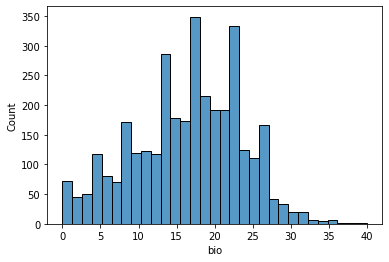

In [115]:
target_mode = 'judging'
text_type = 'bio'

MAX_LEN, num_epochs, learning_rate, batch_size = compute_params(text_type, target_mode)

train_data_df, sentences, labels = sample_frame(df, target_mode, text_type)

import torch.nn.functional as F

labels = F.one_hot(torch.tensor(labels).to(torch.int64), num_classes=2)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sentences, labels, test_size=0.08)

In [116]:
validation_labels

tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        

In [117]:
validation_inputs

array([" 1913. |Ole Miss & UCA Alumna | Football ❤️er | | Empathy, Learner, Command, Intellection, Connectedness | Hotty Toddy | Sic 'em | 1Cor. 16:14",
       ' Daughter of the King. .',
       ' NSFW ART. Comissions closed 19 yrs old // He/Him //',
       ' 🏳️\u200d🌈 ENG/GER OK!! • NB • They/Them • 26 • • Illustrator & Webtoon Artist • full-time fashion consultant • 🔞NSFW • ✉️',
       ' take care of yourself, you deserve to be happy 🌸 • she/her',
       ' . number cruncher.',
       ' Human + dog mama. . @mention alumna. Building global teams and programs @mention (always hiring - DM me!). I rarely tweet, but when I do...my opinions my own 🤓',
       ' CUSE 🍊 ➡️ BOS ☘️ ➡️ DC📍Vegan 🌱 Just came for the music 🎶 ANTI-RACISM 👊🏼 She/Her 💜 Unapologetic advocate for doing what’s right ✊🏼 -T 😌',
       ' Work hard, play hard .. # #LoveYourself',
       ' pat • 21 • • she/her | 𝐨𝐧𝐥𝐲 𝐭𝐡𝐞 𝐥𝐢𝐯𝐢𝐧𝐠 𝐤𝐧𝐨𝐰 𝐯𝐢𝐜𝐭𝐨𝐫𝐲.',
       ' She/Her🧜\u200d♀️Owner @mention Nut🏃\u200d♀️🧘\u200d♀️🫐',
       ' “You’re ne

In [118]:
df

,extravert,thinking,intuitive,judging,bio,liked_tweets,statuses
0,0.0,0.0,0.0,1.0,"Freelance #writer, novelist, Catholic wife an...","['What, after all, is the mission of men if n...",['GUILTY ON ALL COUNTS!!! 'Third degree murde...
1,1.0,0.0,0.0,1.0,", books, food, feminism, and YouTube. Recipe ...",['One punny anti-Trump sign spotted in London...,['I knew immediately where the photo of Task ...
2,0.0,0.0,0.0,1.0,ako lang to ;,['@popesm 'Some people really are living in a...,['one person followed me and one person unfol...
3,0.0,1.0,1.0,1.0,Always a work in progress✨untamed Indigenous....,['There is a lot of disgusting behaviors that...,"['I dunno who did this, but I thank you. ""Rya..."
4,1.0,1.0,1.0,0.0,Professional Photographer 📸 He/him. Opinions=...,['BITCH WE’RE NOMINATED FOR AN MTV AWARD @men...,"[""Viola Davis' dress is gorgeous."", 'Brasil. ..."
...,...,...,...,...,...,...,...
3843,1.0,0.0,1.0,1.0,Mom | | Cardiology MSN RN | activist | femini...,['FOURTEEN WHOLE PAGES? Lookit Tolstoy ovah h...,"""Oh, honey. Don't forget to take off your gla..."
3844,1.0,1.0,0.0,1.0,Emergency Medicine Resident @mention @mention...,['مواطنة سعودية تنجح في زراعة 100 ألف شجرة مو...,['Motivation 💪 'اللهم اجعلنا من أصحاب الحمد ع...
3845,0.0,1.0,1.0,0.0,waiting for an apocalypse • • he/him,['is trimurthi chalaney ok? 'I was awake when...,"['Another day, same crushed hope\nSomething I..."
3846,1.0,0.0,1.0,0.0,I guess I’m bicoastal now | mother of puppies...,"['good evening, clarice '“we’ll figure it out...","['Say after me, I release all negative emotio..."


**BERT Classifier**

In [119]:
print(train_inputs[1])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer([sent for sent in train_inputs], max_length= MAX_LEN, padding= 'max_length', truncation= True)
validation_encodings = tokenizer([sent for sent in validation_inputs], max_length= MAX_LEN,  padding= 'max_length', truncation= True)
import torch

class MBTIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MBTIDataset(train_encodings, train_labels)
val_dataset = MBTIDataset(validation_encodings, validation_labels)

print([batch for batch in train_dataset])

from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW

if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

 Parent, techie, devsecops, queer, dreamer, outdoorsy. #. Quick to smile, terribly shy. Derby saved my soul.. ♌⚧ #queergirl #girlslikeus #derbytwitter


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [120]:
for target_mode in ['thinking', 'intuitive', 'judging']:

    print(target_mode + '\n\n')

    MAX_LEN, num_epochs, learning_rate, batch_size = compute_params(text_type, target_mode)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
    model.to(device)
    model.train()

    train_loader = DataLoader(train_dataset, batch_size= batch_size)
    val_loader = DataLoader(val_dataset, batch_size= 64)

    optim = AdamW(model.parameters(), lr= learning_rate, eps = 1e-8)

    for epoch in range(num_epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
        print('Training...')

        t0 = time.time()

        model.train()

        for step, batch in enumerate(train_loader):

            if step % 40 == 0 and not step == 0:

                elapsed = format_time(time.time() - t0)

              #  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

            optim.zero_grad()

            input_ids = batch['input_ids'].type(torch.LongTensor).detach().to(device)
            attention_mask = batch['attention_mask'].type(torch.LongTensor).detach().to(device)
            labels = batch['labels'].type(torch.LongTensor).detach().to(device)

            outputs = model(input_ids, labels = labels.to(torch.float32))

            loss = outputs.loss
            loss.backward()
            optim.step()


      #  print("")
      #  print("Running Validation...")

        t0 = time.time()

        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        for batch in val_loader:

            b_input_ids = batch['input_ids'].type(torch.LongTensor).to(device)
            b_input_mask = batch['attention_mask'].type(torch.LongTensor).to(device)
            b_labels = batch['labels'].type(torch.LongTensor).to(device)

            with torch.no_grad():

                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, torch.argmax(torch.tensor(label_ids), dim=1))

            eval_accuracy += tmp_eval_accuracy

            nb_eval_steps += 1

        print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
      #  print("  Validation took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Training complete!")

    output_dir = 'C:/Users/parth/PycharmProjects/Language Models/Models/' + 'bert_'+target_mode+ "_" + text_type

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

thinking




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
  Accuracy: 0.54

======== Epoch 2 / 3 ========
Training...
  Accuracy: 0.57

======== Epoch 3 / 3 ========
Training...
  Accuracy: 0.54

Training complete!
Saving model to C:/Users/parth/PycharmProjects/Language Models/Models/bert_thinking_bio
intuitive




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
  Accuracy: 0.52

======== Epoch 2 / 3 ========
Training...
  Accuracy: 0.53

======== Epoch 3 / 3 ========
Training...
  Accuracy: 0.53

Training complete!
Saving model to C:/Users/parth/PycharmProjects/Language Models/Models/bert_intuitive_bio
judging




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Accuracy: 0.54

======== Epoch 2 / 4 ========
Training...
  Accuracy: 0.54

======== Epoch 3 / 4 ========
Training...
  Accuracy: 0.55

======== Epoch 4 / 4 ========
Training...
  Accuracy: 0.50

Training complete!
Saving model to C:/Users/parth/PycharmProjects/Language Models/Models/bert_judging_bio


In [95]:
!nvidia-smi

Thu Oct  7 19:56:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.13       Driver Version: 462.13       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 307... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P0    34W /  N/A |   4653MiB /  8192MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("k-partha/bert_extravert_bio")

model = AutoModelForSequenceClassification.from_pretrained("k-partha/bert_extravert_bio")

model.eval()
string = "partying!"

string = tokenizer(string, return_tensors="pt")["input_ids"]
outputs = model(string)

import torch.nn as nn

In [96]:
import torch.nn as nn

m = nn.Softmax(dim = 1)
print(m(outputs.logits))

tensor([[0.3902, 0.6098],
        [0.5923, 0.4077],
        [0.2556, 0.7444],
        [0.1293, 0.8707],
        [0.2521, 0.7479],
        [0.0770, 0.9230],
        [0.2777, 0.7223],
        [0.1079, 0.8921],
        [0.0461, 0.9539],
        [0.2451, 0.7549],
        [0.2188, 0.7812],
        [0.1267, 0.8733],
        [0.2642, 0.7358],
        [0.1443, 0.8557],
        [0.1647, 0.8353],
        [0.2996, 0.7004],
        [0.5163, 0.4837],
        [0.5645, 0.4355],
        [0.2512, 0.7488]], device='cuda:0')


In [97]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("k-partha/extrabert_bio")

model = AutoModelForSequenceClassification.from_pretrained("k-partha/extrabert_bio")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/885 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [99]:
model
string = "Teetering bulb of dread and dream"
string = tokenizer(string, return_tensors="pt")
outputs = model(**string)
print(outputs)
print(m(outputs.logits))

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1269, -0.1437]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
tensor([[0.5672, 0.4328]], grad_fn=<SoftmaxBackward>)


In [131]:
df.columns

Index(['extravert', 'thinking', 'intuitive', 'judging', 'bio', 'liked_tweets',
       'statuses'],
      dtype='object')

In [136]:
write_file = open('C:/Users/parth/PycharmProjects/Language Models/' +'MASTER_DATA_CSV.csv', mode= 'w+', encoding= 'utf-16')

origin_df[['statuses','bio','liked_tweets','extravert', 'thinking', 'intuitive', 'judging' ]].to_csv(write_file)

df.to_csv()